In [1]:
## Import Libraries
%matplotlib inline
from IPython.display import Image, HTML
import json
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
import warnings; warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
from ast import literal_eval
sns.set_style('whitegrid')
sns.set(font_scale=1.25)
pd.set_option('display.max_colwidth', 50)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from keras import preprocessing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MultiLabelBinarizer
import os

Using TensorFlow backend.


In [11]:
# read data
credits = pd.read_csv('credits.csv')
df = pd.read_csv('movies_metadata.csv')

In [6]:
df.head(1)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0


In [12]:
'Helper function to get director from Credits data'
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

'Helper function to get type of data in a series' 
def gettype(x):
    return type(x)


'Helper function to get director from Credits data'

'Helper function to get type of data in a series'

In [13]:
' Helper functions fpor Pre-processing cast'
def process_cast(x):
    new = []
    for i in x:
        i = i.replace(' ','')
        new.append(i)
    return new

def process_cast2(x):
    seperator = ' '
    y = seperator.join(x)
    return y

def process_cast3(x):
    x = x.replace('.','')
    x = x.replace('-','')
    
    return x

' Helper functions fpor Pre-processing cast'

In [14]:
df = df[['genres', 'id', 'title', 'overview']]
df.overview = df.overview.str.lower()
df.title = df.title.str.lower()
df['genres'] = df['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
credits['cast'] = credits['cast'].apply(literal_eval)
credits['crew'] = credits['crew'].apply(literal_eval)
credits['director'] = credits['crew'].apply(get_director)
credits['cast'] = credits['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
credits = credits[['cast','id','director']]
df = df[df.id != '1997-08-20']
df = df[df.id != '2012-09-29']
df = df[df.id != '2014-01-01']
df.id = df.id.astype('int64')
finalData = pd.merge(left= df, right=credits, how='inner')

topActors = 5 # getting only top 5 actors
finalData.cast = finalData.cast.apply(lambda x: x[:topActors])
finalData['dir_code'] = finalData.director.astype('category').cat.codes # generating code for director
finalData['Id_code'] = finalData.id.astype('category').cat.codes # generating code for ID

# clean up over view to remove nulls
finalData['overviewCheck'] = finalData.overview.apply(gettype)
finalData = finalData[finalData.overviewCheck == str]
finalData.drop(['overviewCheck'], axis = 1, inplace=True)

In [15]:
finalData.head(10)

,genres,id,title,overview,cast,director,dir_code,Id_code
0,"[Animation, Comedy, Family]",862,toy story,"led by woody, andy's toys live happily in his ...","[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",John Lasseter,8138,682
1,"[Adventure, Fantasy, Family]",8844,jumanji,when siblings judy and peter discover an encha...,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",Joe Johnston,7891,2984
2,"[Romance, Comedy]",15602,grumpier old men,a family wedding reignites the ancient feud be...,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",Howard Deutch,6406,7181
3,"[Comedy, Drama, Romance]",31357,waiting to exhale,"cheated on, mistreated and stepped on, the wom...","[Whitney Houston, Angela Bassett, Loretta Devi...",Forest Whitaker,5002,13291
4,[Comedy],11862,father of the bride part ii,just when george banks has recovered from his ...,"[Steve Martin, Diane Keaton, Martin Short, Kim...",Charles Shyer,2547,5217
5,"[Action, Crime, Drama, Thriller]",949,heat,"obsessive master thief, neil mccauley leads a ...","[Al Pacino, Robert De Niro, Val Kilmer, Jon Vo...",Michael Mann,11408,758
6,"[Comedy, Romance]",11860,sabrina,an ugly duckling having undergone a remarkable...,"[Harrison Ford, Julia Ormond, Greg Kinnear, An...",Sydney Pollack,15795,5215
7,"[Action, Adventure, Drama, Family]",45325,tom and huck,"a mischievous young boy, tom sawyer, witnesses...","[Jonathan Taylor Thomas, Brad Renfro, Rachael ...",Peter Hewitt,13026,18757
8,"[Action, Adventure, Thriller]",9091,sudden death,international action superstar jean claude van...,"[Jean-Claude Van Damme, Powers Boothe, Dorian ...",Peter Hyams,13030,3159
9,"[Adventure, Action, Thriller]",710,goldeneye,james bond must unmask the mysterious head of ...,"[Pierce Brosnan, Sean Bean, Izabella Scorupco,...",Martin Campbell,10797,563


In [16]:
finalData = finalData[(finalData.dir_code != -1) & 
            (finalData.genres.apply(len) > 0) & (finalData.Id_code != -1) & (finalData.cast.apply(len) > 0)]

In [17]:
finalData['dir_code'] = finalData.director.astype('category').cat.codes

In [19]:
finalData

,genres,id,title,overview,cast,director,dir_code,Id_code
0,"[Animation, Comedy, Family]",862,toy story,"led by woody, andy's toys live happily in his ...","[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",John Lasseter,7303,682
1,"[Adventure, Fantasy, Family]",8844,jumanji,when siblings judy and peter discover an encha...,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",Joe Johnston,7080,2984
2,"[Romance, Comedy]",15602,grumpier old men,a family wedding reignites the ancient feud be...,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",Howard Deutch,5736,7181
3,"[Comedy, Drama, Romance]",31357,waiting to exhale,"cheated on, mistreated and stepped on, the wom...","[Whitney Houston, Angela Bassett, Loretta Devi...",Forest Whitaker,4472,13291
4,[Comedy],11862,father of the bride part ii,just when george banks has recovered from his ...,"[Steve Martin, Diane Keaton, Martin Short, Kim...",Charles Shyer,2280,5217
5,"[Action, Crime, Drama, Thriller]",949,heat,"obsessive master thief, neil mccauley leads a ...","[Al Pacino, Robert De Niro, Val Kilmer, Jon Vo...",Michael Mann,10231,758
6,"[Comedy, Romance]",11860,sabrina,an ugly duckling having undergone a remarkable...,"[Harrison Ford, Julia Ormond, Greg Kinnear, An...",Sydney Pollack,14163,5215
7,"[Action, Adventure, Drama, Family]",45325,tom and huck,"a mischievous young boy, tom sawyer, witnesses...","[Jonathan Taylor Thomas, Brad Renfro, Rachael ...",Peter Hewitt,11673,18757
8,"[Action, Adventure, Thriller]",9091,sudden death,international action superstar jean claude van...,"[Jean-Claude Van Damme, Powers Boothe, Dorian ...",Peter Hyams,11677,3159
9,"[Adventure, Action, Thriller]",710,goldeneye,james bond must unmask the mysterious head of ...,"[Pierce Brosnan, Sean Bean, Izabella Scorupco,...",Martin Campbell,9695,563


In [47]:
finalData.shape

(40418, 8)

In [21]:
total_dir = len(finalData.dir_code.unique())
total_dir

15737

In [31]:
# tokenizing and seqnecing overview 
max_words = 10000
maxlen = 300

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(finalData.overview)
sequences = tokenizer.texts_to_sequences(finalData.overview)


word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

overview_seq = pad_sequences(sequences, maxlen=maxlen, padding='post')

overview_wordIndex = tokenizer.word_index
overview_Indexword = tokenizer.index_word

Found 80903 unique tokens.


In [64]:
overview_seq.shape

(40418, 300)

In [48]:
# Creating one hot encoding of Genres
mlb = MultiLabelBinarizer()
mlb.fit(finalData.genres)
Y_genres = mlb.transform(finalData.genres)
Y_labels = mlb.classes_

MultiLabelBinarizer(classes=None, sparse_output=False)

In [52]:
finalData.cast = finalData.cast.apply(process_cast)
finalData.cast = finalData.cast.apply(process_cast2)
finalData.cast = finalData.cast.apply(process_cast3)

In [53]:
finalData.head(10)

,genres,id,title,overview,cast,director,dir_code,Id_code
0,"[Animation, Comedy, Family]",862,toy story,"led by woody, andy's toys live happily in his ...",TomHanks TimAllen DonRickles JimVarney Wallace...,John Lasseter,7303,682
1,"[Adventure, Fantasy, Family]",8844,jumanji,when siblings judy and peter discover an encha...,RobinWilliams JonathanHyde KirstenDunst Bradle...,Joe Johnston,7080,2984
2,"[Romance, Comedy]",15602,grumpier old men,a family wedding reignites the ancient feud be...,WalterMatthau JackLemmon AnnMargret SophiaLore...,Howard Deutch,5736,7181
3,"[Comedy, Drama, Romance]",31357,waiting to exhale,"cheated on, mistreated and stepped on, the wom...",WhitneyHouston AngelaBassett LorettaDevine Lel...,Forest Whitaker,4472,13291
4,[Comedy],11862,father of the bride part ii,just when george banks has recovered from his ...,SteveMartin DianeKeaton MartinShort KimberlyWi...,Charles Shyer,2280,5217
5,"[Action, Crime, Drama, Thriller]",949,heat,"obsessive master thief, neil mccauley leads a ...",AlPacino RobertDeNiro ValKilmer JonVoight TomS...,Michael Mann,10231,758
6,"[Comedy, Romance]",11860,sabrina,an ugly duckling having undergone a remarkable...,HarrisonFord JuliaOrmond GregKinnear AngieDick...,Sydney Pollack,14163,5215
7,"[Action, Adventure, Drama, Family]",45325,tom and huck,"a mischievous young boy, tom sawyer, witnesses...",JonathanTaylorThomas BradRenfro RachaelLeighCo...,Peter Hewitt,11673,18757
8,"[Action, Adventure, Thriller]",9091,sudden death,international action superstar jean claude van...,JeanClaudeVanDamme PowersBoothe DorianHarewood...,Peter Hyams,11677,3159
9,"[Adventure, Action, Thriller]",710,goldeneye,james bond must unmask the mysterious head of ...,PierceBrosnan SeanBean IzabellaScorupco FamkeJ...,Martin Campbell,9695,563


In [54]:
# creating coded sequences of Cast 
total_actors = 50000

tokenizer_actor = Tokenizer(total_actors)
tokenizer_actor.fit_on_texts(finalData.cast)
actor_seq = tokenizer_actor.texts_to_sequences(finalData.cast)

actor_index = tokenizer_actor.word_index
print('Found %s unique tokens.' % len(actor_index))

actor_array = pad_sequences(actor_seq, maxlen=topActors, padding='post')


Found 69354 unique tokens.


In [63]:
actor_array.shape

(40418, 5)

In [65]:
train_y = Y_genres
x1_overview = overview_seq
x2_actors = actor_array
x3_dir = finalData.dir_code

len_overview = maxlen
len_actor = topActors

In [66]:
train_y.shape

(40418, 20)

In [17]:
trainSize = finalData.shape[0]

In [67]:
x1_overview.shape
x2_actors.shape
x3_dir.shape

print('total words in Overview', max_words)
print('total unique actors', total_actors)
print('total unique directors', total_dir)


(40418, 300)

(40418, 5)

(40418,)

total words in Overview 10000
total unique actors 50000
total unique directors 15737


In [68]:
from keras.layers import Embedding, Flatten, Dense, merge, Input
from keras.utils import plot_model

In [69]:
from keras.models import Model

In [70]:
input_dir = Input(shape =(1,))

In [71]:
input_overview = Input(shape = (300,))

In [72]:
input_actor = Input(shape=(5,))

In [73]:
dir_embed = Embedding(input_dim=15737, output_dim=16)(input_dir)
overview_embed = Embedding(input_dim=10000,output_dim=100, input_length=len_overview)(input_overview)
actor_embed = Embedding(input_dim=50000, output_dim= 16, input_length=topActors)(input_actor)

In [74]:
path1 = Flatten()(dir_embed)
path2 = Flatten()(overview_embed)
path3 = Flatten()(actor_embed)

In [75]:
import keras

In [80]:
mergeLayer = keras.layers.concatenate([path1,path2,path3])

In [84]:
dense1 = Dense(32, activation='relu')(mergeLayer)

In [85]:
outputLayer = Dense(20, activation='sigmoid')(dense1)

In [86]:
model1 = keras.Model([input_dir,input_overview,input_actor],outputLayer)

In [87]:
model1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 5)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 16)        251792      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_

In [88]:
model1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [89]:
model1.fit(x=[x3_dir,x1_overview,x2_actors],y=train_y, batch_size=32, epochs=20)

Epoch 1/20
40418/40418 [==============================] - 56s 1ms/step - loss: 0.2739 - acc: 0.8990
Epoch 2/20
40418/40418 [==============================] - 58s 1ms/step - loss: 0.2209 - acc: 0.9164
Epoch 3/20
40418/40418 [==============================] - 56s 1ms/step - loss: 0.1795 - acc: 0.9326
Epoch 4/20
40418/40418 [==============================] - 56s 1ms/step - loss: 0.1402 - acc: 0.9487
Epoch 5/20
40418/40418 [==============================] - 56s 1ms/step - loss: 0.1028 - acc: 0.9635
Epoch 6/20
40418/40418 [==============================] - 53s 1ms/step - loss: 0.0713 - acc: 0.9757
Epoch 7/20
40418/40418 [==============================] - 47s 1ms/step - loss: 0.0470 - acc: 0.9848
Epoch 8/20
40418/40418 [==============================] - 47s 1ms/step - loss: 0.0300 - acc: 0.9909
Epoch 9/20
40418/40418 [==============================] - 48s 1ms/step - loss: 0.0186 - acc: 0.9948
Epoch 10/20
40418/40418 [==============================] - 47s 1ms/step - loss: 0.0114 - acc: 0.9971

In [90]:
model1.save('embeddingMovies_model1.h5')

In [91]:
m1 = keras.models.load_model('embeddingMovies_model1.h5')

In [92]:
m1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 5)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 16)        251792      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_

In [101]:
dir_embeddings = m1.layers[3].get_weights()[0]

In [102]:
dir_embeddings.shape

(15737, 16)

In [103]:
dir_embeddings[0]

array([ 0.00216709, -0.04420674, -0.03350094,  0.03986413,  0.0293476 ,
        0.02707118,  0.0424908 , -0.0473018 ,  0.09203498, -0.05398054,
        0.03347248,  0.03531959, -0.020546  , -0.06762767,  0.07390381,
       -0.01470217], dtype=float32)

In [104]:
x3_dir[0]

7303

In [105]:
dir_embeddings[max(x3_dir)]

array([ 0.03367157,  0.02438976,  0.01464593,  0.04606984,  0.02835344,
       -0.03152869,  0.03227799, -0.02690234, -0.0457334 , -0.00886561,
        0.05157458, -0.00939572, -0.03322063, -0.03614559, -0.01186791,
       -0.00265257], dtype=float32)

In [106]:
finalData.head()

,genres,id,title,overview,cast,director,dir_code,Id_code
0,"[Animation, Comedy, Family]",862,toy story,"led by woody, andy's toys live happily in his ...",TomHanks TimAllen DonRickles JimVarney Wallace...,John Lasseter,7303,682
1,"[Adventure, Fantasy, Family]",8844,jumanji,when siblings judy and peter discover an encha...,RobinWilliams JonathanHyde KirstenDunst Bradle...,Joe Johnston,7080,2984
2,"[Romance, Comedy]",15602,grumpier old men,a family wedding reignites the ancient feud be...,WalterMatthau JackLemmon AnnMargret SophiaLore...,Howard Deutch,5736,7181
3,"[Comedy, Drama, Romance]",31357,waiting to exhale,"cheated on, mistreated and stepped on, the wom...",WhitneyHouston AngelaBassett LorettaDevine Lel...,Forest Whitaker,4472,13291
4,[Comedy],11862,father of the bride part ii,just when george banks has recovered from his ...,SteveMartin DianeKeaton MartinShort KimberlyWi...,Charles Shyer,2280,5217


In [107]:
director_df = finalData[['director','dir_code']]

In [108]:
director_df = director_df.drop_duplicates()

In [109]:
def get_dir_vectors(dir_code):
    return dir_embeddings[dir_code]

In [110]:
director_df['vectors'] = director_df.dir_code.apply(get_dir_vectors)

In [111]:
director_df.head()

,director,dir_code,vectors
0,John Lasseter,7303,"[0.041945044, 0.20666566, -0.15569817, -0.0513..."
1,Joe Johnston,7080,"[-0.045694444, -0.0045052813, -0.051924344, -0..."
2,Howard Deutch,5736,"[0.026984464, 0.09053287, -0.0013844261, -0.00..."
3,Forest Whitaker,4472,"[0.008149793, 0.049845427, -0.09402254, -0.008..."
4,Charles Shyer,2280,"[0.103952974, 0.06516091, -0.09382679, -0.0250..."


In [112]:
vectorList = pd.DataFrame(director_df.vectors.values.tolist())

In [113]:
from sklearn.manifold import TSNE

In [114]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(vectorList)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 15737 samples in 0.023s...
[t-SNE] Computed neighbors for 15737 samples in 9.829s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15737
[t-SNE] Computed conditional probabilities for sample 2000 / 15737
[t-SNE] Computed conditional probabilities for sample 3000 / 15737
[t-SNE] Computed conditional probabilities for sample 4000 / 15737
[t-SNE] Computed conditional probabilities for sample 5000 / 15737
[t-SNE] Computed conditional probabilities for sample 6000 / 15737
[t-SNE] Computed conditional probabilities for sample 7000 / 15737
[t-SNE] Computed conditional probabilities for sample 8000 / 15737
[t-SNE] Computed conditional probabilities for sample 9000 / 15737
[t-SNE] Computed conditional probabilities for sample 10000 / 15737
[t-SNE] Computed conditional probabilities for sample 11000 / 15737
[t-SNE] Computed conditional probabilities for sample 12000 / 15737
[t-SNE] Computed conditional probabilities for sa

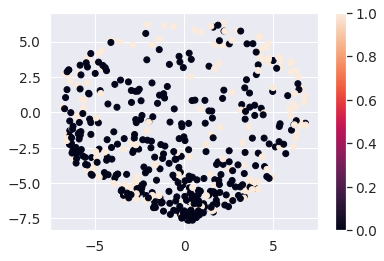

In [115]:
tsne1 = pd.DataFrame(tsne_results.tolist(), columns= ['ts_1','ts_2'])
director_df.reset_index(inplace=True)
temp2 = pd.merge(left= director_df, right=tsne1, left_index=True, right_index=True, how= 'outer')
temp2.drop(['index'],axis = 1,inplace=True)

temp1 = finalData[['dir_code','genres']]
df_genres =  pd.get_dummies(temp1.genres.apply(pd.Series).stack()).sum(level=0)

temp1 = pd.concat([temp1,df_genres], axis = 1)

dir_genre = temp1.groupby(['dir_code'])['Action','Comedy','Crime','Drama','Adventure','Romance','Science Fiction'].agg(sum)

dir_genre.reset_index(inplace=True)

dir_final = pd.merge(left= temp2, right=dir_genre, how = 'outer')


dir_final['Comedy_Score'] = 0
dir_final['Comedy_Score'][dir_final.Comedy >= np.mean(dir_final.Comedy)] = 1

dir_final['SciFi_score'] = 0
dir_final['SciFi_score'][dir_final['Science Fiction'] >= np.mean(dir_final['Science Fiction'])] = 1

plt.scatter(dir_final.ts_1[:500],dir_final.ts_2[:500], c = dir_final.SciFi_score[:500])
plt.colorbar()